In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
import multivelo as mv

In [2]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.left'] = True
matplotlib.rcParams['ytick.right'] = False

In [4]:
multivelo = anndata.read_h5ad(
    '../data/Mouse_skin/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Mouse_skin/celldancer.h5ad')

In [5]:

adata_out = anndata.read_h5ad(
    '../data/Mouse_skin/adata_out.moflow.h5ad')

saving figure to file ../figures/fig4A_mosync.svg


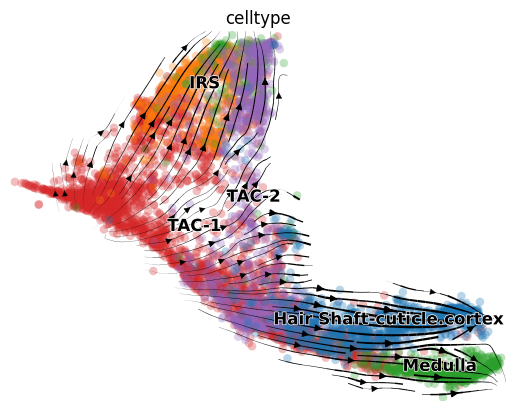

In [6]:
scv.pl.velocity_embedding_stream(adata_out,
                                 vkey='velo_s',
                                 color='celltype',
                                 save='../figures/fig4A_mosync.svg')

In [6]:
pseudotime_ = np.zeros(adata_out.n_obs)
pseudotime_[np.argsort(adata_out.obs['velo_s_pseudotime'])] = np.arange(adata_out.n_obs)
adata_out.obs['velo_s_pseudotime_'] = pseudotime_/adata_out.n_obs

saving figure to file ../figures/fig4A_time.pdf


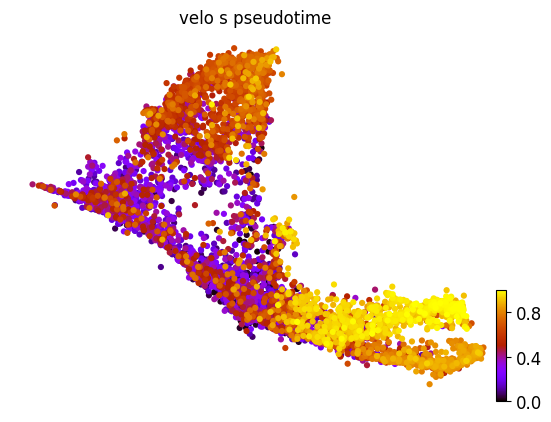

In [11]:
scv.pl.scatter(adata_out,
                color='velo_s_pseudotime_', cmap='gnuplot', size=80,
                save='../figures/fig4A_time.pdf')

computing velocity embedding


    finished (0:00:01) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/fig4A_multivelo.svg


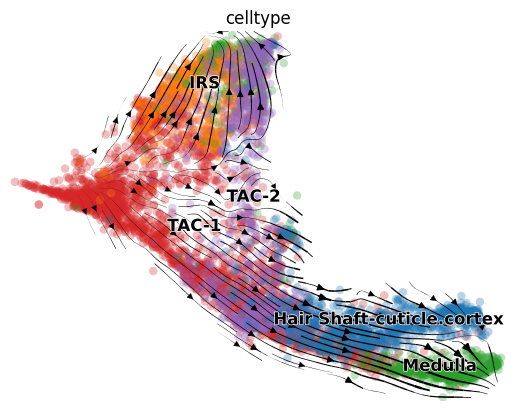

In [12]:
scv.pl.velocity_embedding_stream(multivelo,
                                 vkey='velo_s_norm',
                                 color='celltype',
                                 save='../figures/fig4A_multivelo.svg')

saving figure to file ../figures/fig4A_celldancer.svg


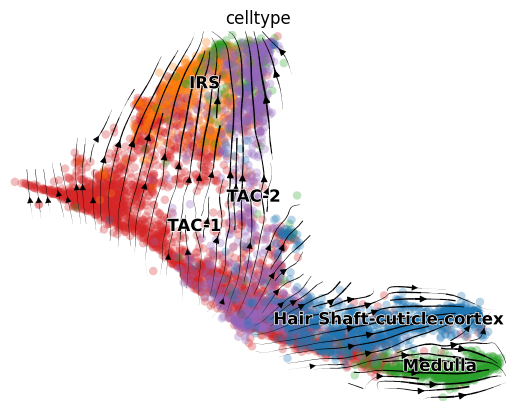

In [13]:
scv.pl.velocity_embedding_stream(celldancer,
                                 vkey='velo_s',
                                 color='celltype',
                                 save='../figures/fig4A_celldancer.svg')

In [7]:
scv.tl.score_genes_cell_cycle(adata_out)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


saving figure to file ../figures/fig4_g2m.pdf


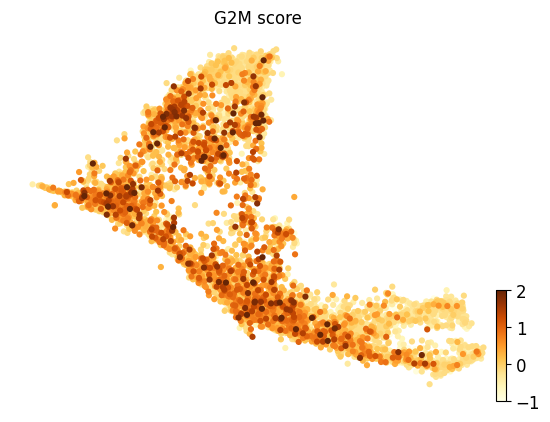

In [8]:
scv.pl.scatter(adata_out, color='G2M_score', vmax=2, vmin=-1,cmap='YlOrBr',
               size=80, save='../figures/fig4_g2m.pdf')

In [6]:
cluster_edges = (('TAC-1', 'TAC-2'), ('TAC-2', 'Hair Shaft-cuticle.cortex'),
                 ('TAC-2', 'IRS'), ('TAC-2', 'Medulla'))

In [7]:
cbdir = {}
cbdir['moflow'] = mf.cross_boundary_correctness(adata_out, 'celltype', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['celldancer'] = mf.cross_boundary_correctness(celldancer, 'celltype', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['multivelo'] = mf.cross_boundary_correctness(multivelo, 'celltype', 'velo_s_norm', cluster_edges,
                                          True, 'X_umap')

In [8]:
cbdir_ = []
for k in cbdir.values():
    temp = {}
    for c, s in k.items():
        s = np.mean(s)
        temp[c] = s
    cbdir_.append(temp)
    
cbdir_ = pd.DataFrame(cbdir_, index=cbdir.keys())

In [9]:
cbdir_


,"(TAC-1, TAC-2)","(TAC-2, Hair Shaft-cuticle.cortex)","(TAC-2, IRS)","(TAC-2, Medulla)"
moflow,0.065798,0.158649,0.004245,0.327641
celldancer,-0.019090,-0.275042,0.266065,0.103872
multivelo,0.105460,0.213890,-0.023570,0.296995


In [11]:
print(cbdir_.mean(axis=1))
print(cbdir_.std(axis=1))

moflow        0.139083
celldancer    0.018951
multivelo     0.148194
dtype: float64
moflow        0.140818
celldancer    0.228149
multivelo     0.138789
dtype: float64


In [32]:
adata_out.obs['celltype'] = pd.Categorical(adata_out.obs['celltype'],
                                           ['TAC-1', 'TAC-2', 'Hair Shaft-cuticle.cortex', 'IRS', 'Medulla', ])


In [33]:
adata_out.uns['celltype_colors'] = ['#d62728', '#9467bd','#1f77b4', '#ff7f0e', '#2ca02c', ]

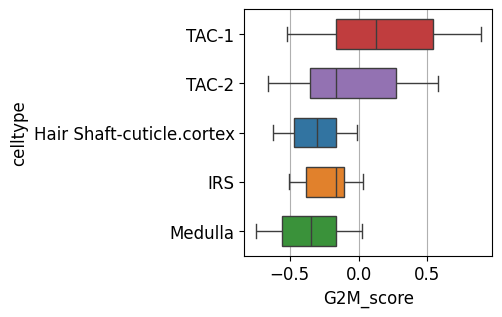

In [16]:
fig, ax = plt.subplots(figsize=(3.2, 3.2), )
sns.boxplot(adata_out.obs, y='celltype', x='G2M_score', palette=adata_out.uns['celltype_colors'],
            width=.6, whis=.5, showfliers=False,
)
plt.grid(axis='x')
fig.savefig('../figures/fig4D_g2m.pdf')

In [22]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    #ww = wu|ws&down
    ww = wu|ws
    ww |= (vu * vs >= 0)
    
    on_[i] = np.mean((vu[w_non_zero]>0)&(vs[w_non_zero]>0))
    off_[i] = np.mean((vu[w_non_zero]<0)&(vs[w_non_zero]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    #m1_[i] = np.mean((vc[ww]<0))
    #m2_[i] = np.mean((vc[ww]>=0))

In [23]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_},
                    index=adata_out.var_names)

In [24]:
genelist = set(adata_out.var_names) & set(multivelo.var_names)
adata_out_ = adata_out[:, adata_out.var_names.isin(genelist)]
multivelo_ = multivelo[:, multivelo.var_names.isin(genelist)]
temp_ = temp.loc[ multivelo_.var_names.values]

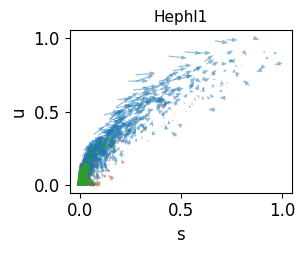

In [32]:
fig, ax = mf.scatter_gene(adata_out, 'Hephl1', color_by='celltype', velocity_arrows=True)
fig.savefig('../figures/fig4E_mf.pdf')

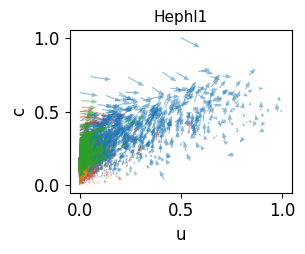

In [41]:
fig, ax = mf.scatter_gene(adata_out, 'Hephl1', color_by='celltype', velocity_arrows=True,
                          by='cu')

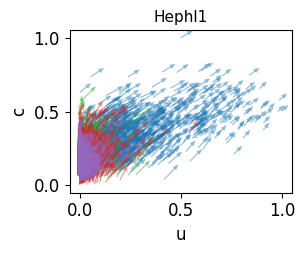

In [40]:
fig, ax = mf.scatter_gene(multivelo, 'Hephl1', color_by='celltype', velocity_arrows=True,
                          by='cu')
#fig.savefig('../figures/fig4E_mf.pdf')

In [39]:
celldancer.layers['Mc'] = np.zeros_like(celldancer.layers['Ms'])
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

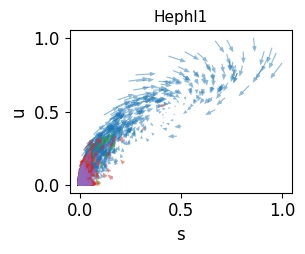

In [15]:
fig, ax = mf.scatter_gene(celldancer, 'Hephl1', color_by='celltype', velocity_arrows=True)
fig.savefig('../figures/fig4E_cd.pdf')

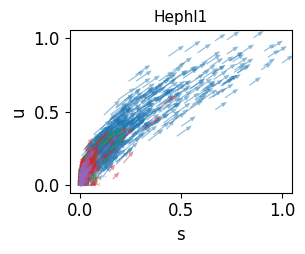

In [16]:
fig, ax = mf.scatter_gene(multivelo, 'Hephl1', color_by='celltype', velocity_arrows=True)
fig.savefig('../figures/fig4E_mv.pdf')

In [6]:
adata_out.layers['transcription'] = adata_out.layers['alpha'] * adata_out.layers['c']

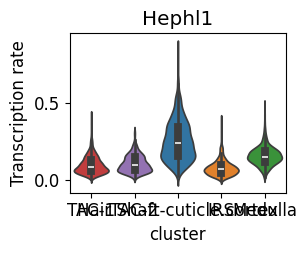

In [34]:
fig, ax = mf.gene.violinplot(adata_out, 'Hephl1', by='transcription')
ax[0][0].set_ylabel('Transcription rate')
fig.savefig('../figures/fig4F_tr.pdf')

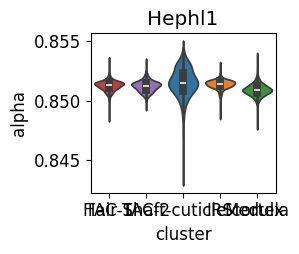

In [37]:
fig, ax = mf.gene.violinplot(adata_out, 'Hephl1', by='alpha')
fig.savefig('../figures/fig4F_alpha.pdf')

In [38]:
celldancer.obs['celltype'] = pd.Categorical(celldancer.obs['celltype'],
                                           ['TAC-1', 'TAC-2', 'Hair Shaft-cuticle.cortex', 'IRS', 'Medulla', ])
celldancer.uns['celltype_colors'] = ['#d62728', '#9467bd','#1f77b4', '#ff7f0e', '#2ca02c', ]

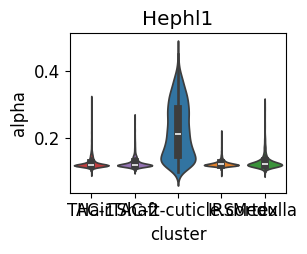

In [39]:
fig, ax = mf.gene.violinplot(celldancer, 'Hephl1', by='alpha')
fig.savefig('../figures/fig4F_cd_alpha.pdf')

In [12]:
multivelo.layers['transcription'] = multivelo.layers['ATAC']*multivelo.var['fit_alpha'].values

In [23]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    ww = wu|ws

    on_[i] = np.mean((vu[ww]>0)&(vs[ww]>0))
    off_[i] = np.mean((vu[ww]<0)&(vs[ww]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    
    if (np.mean(vu[ww]>0) > .7) & (np.mean(vs[ww]>0) >.7):
        model[i] = 'on'
    elif (np.mean(vu[ww]<0) > 0.8) & (np.mean(vs[ww]<0)>.8):
        model[i] = 'off'
    else:
        if np.mean(vc[ww]>0) > 0.5:
            model[i] = 'm2'
        else:
            model[i] = 'm1'
    

In [24]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_,
                     'model': model},
                    index=adata_out.var_names)

In [25]:
np.unique(temp['model'], return_counts=True)

(array(['m1', 'm2', 'off', 'on'], dtype=object), array([571, 231,   5, 155]))

In [26]:
genelist = set(adata_out.var_names) & set(multivelo.var_names)
adata_out_ = adata_out[:, adata_out.var_names.isin(genelist)]
multivelo_ = multivelo[:, multivelo.var_names.isin(genelist)]

In [29]:
fitstate_cu = np.zeros_like(adata_out.layers['c'])
fitstate_cu[(adata_out.layers['velo_c']>0) & (adata_out.layers['velo_u']<0)] = 1
fitstate_cu[(adata_out.layers['velo_c']>0) & (adata_out.layers['velo_u']>0)] = 2
fitstate_cu[(adata_out.layers['velo_c']<0) & (adata_out.layers['velo_u']>0)] = 3
fitstate_cu[(adata_out.layers['velo_c']<0) & (adata_out.layers['velo_u']<0)] = 4
fitstate_cu[(adata_out.layers['c']<0.05) & (adata_out.layers['u']<0.05) & (adata_out.layers['s']<0.05)] = 0
adata_out.layers['fit_state_cu'] = fitstate_cu

In [30]:
fitstate_us = np.zeros_like(adata_out.layers['c'])
fitstate_us[(adata_out.layers['velo_u']>0) & (adata_out.layers['velo_s']<0)] = 1
fitstate_us[(adata_out.layers['velo_u']>0) & (adata_out.layers['velo_s']>0)] = 2
fitstate_us[(adata_out.layers['velo_u']<0) & (adata_out.layers['velo_s']>0)] = 3
fitstate_us[(adata_out.layers['velo_u']<0) & (adata_out.layers['velo_s']<0)] = 4
fitstate_us[(adata_out.layers['c']<0.05) & (adata_out.layers['u']<0.05) & (adata_out.layers['s']<0.05)] = 0
adata_out.layers['fit_state_us'] = fitstate_us

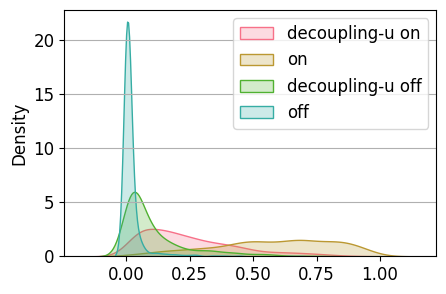

In [32]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
for i, title in enumerate(['decoupling-u on', 'on', 'decoupling-u off', 'off']):
    prop = np.mean(adata_out.layers['fit_state_us']==i+1, axis=0)
    sns.kdeplot(prop, label=title, fill=True, color=sns.color_palette('husl')[i])
plt.legend()
ax.grid(axis='y')
fig.savefig('../figures/fig4B_usstate.pdf')

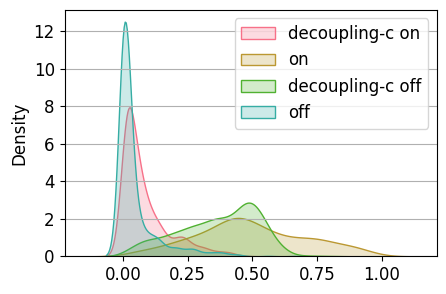

In [33]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
for i, title in enumerate(['decoupling-c on', 'on', 'decoupling-c off', 'off']):
    prop = np.mean(adata_out.layers['fit_state_cu']==i+1, axis=0)
    sns.kdeplot(prop, label=title, fill=True, color=sns.color_palette('husl')[i])
plt.legend()
ax.grid(axis='y')
fig.savefig('../figures/fig4B_custate.pdf')

In [17]:
?mv.pie_summary

Signature: mv.pie_summary(adata, genes=None)
Docstring:
Summary of directions and models.

This function plots a pie chart for (pre-determined or specified)
directions and models.
`induction`: induction-only genes.
`repression`: repression-only genes.
`Model 1`: model 1 complete genes.
`Model 2`: model 2 complete genes.

Parameters
----------
adata: :class:`~anndata.AnnData`
    Anndata result from dynamics recovery.
genes: `str`,  list of `str` (default: `None`)
    If `None`, will use all fitted genes.
File:      ~/anaconda3/envs/mosync/lib/python3.10/site-packages/multivelo/dynamical_chrom_func.py
Type:      function

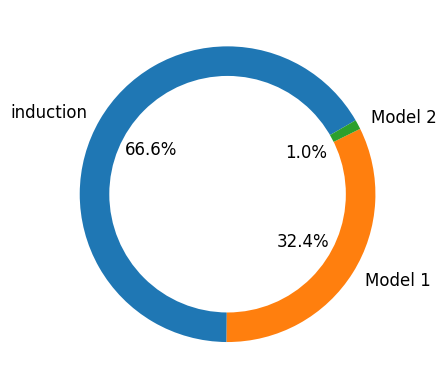

In [18]:
mv.pie_summary(multivelo)
plt.savefig('../figures/fig4B_pie.pdf')